# Single-cell RNA sequencing data analysis tutorial

In this first session, we will preprocess and cell type a [dataset of peripheral blood mononuclear cells](https://www.10xgenomics.com/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0) (PBMCs).

Useful links:
* [anndata](https://anndata.readthedocs.io/en/stable/)
* [scanpy](https://scanpy.readthedocs.io/en/stable/)
* [Single-cell best practices book](https://www.sc-best-practices.org/preamble.html)

## Library imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc

# `DATA_DIR` is a pathlib Path pointing to this repo's data directory.
# You can specify a path with the syntax `DATA_DIR / path / to / file`.
# Note: This import command only works if you followed the first installation instructions!
from crabs import DATA_DIR

## General settings

In [2]:
# Set the verbosity of Scanpy to 2
sc.settings.verbosity = 2

## Constants

## Function definitions

## Data loading

In [3]:
# Load the PBMC data into the AnnData format
adata = sc.read_10x_h5(DATA_DIR / "pbmc" / "raw" / "pbmc_10k_v3_filtered_feature_bc_matrix.h5")
adata

reading /Users/philipp/code/crabs2025/data/pbmc/raw/pbmc_10k_v3_filtered_feature_bc_matrix.h5
 (0:00:00)


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

## Data exploration

In [4]:
# Follow the instruction issued when loading the data
# Makes all gene names unique
adata.var_names_make_unique()

In [5]:
# How many cells and genes does the data contain?
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

Number of cells: 11769
Number of genes: 33538


In [6]:
# Which format is the data saved as? Why?
print(f"Count data type: {type(adata.X)}")

# scRNA-seq data is very sparse, i.e., has many zeros entries
print(f"Percentage of non-zero counts: {adata.X.getnnz() / adata.n_obs / adata.n_vars * 100:.3}%")

Count data type: <class 'scipy.sparse._csr.csr_matrix'>
Percentage of non-zero counts: 6.29%


## Quality control

In [7]:
# Remove cells with less than 100 transcripts
sc.pp.filter_cells(adata, min_counts=100)
adata

AnnData object with n_obs × n_vars = 11769 × 33538
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
# Remove genes expressed in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
adata

filtered out 16011 genes that are detected in less than 10 cells


AnnData object with n_obs × n_vars = 11769 × 17527
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [9]:
# Detect mitochondrial genes and add a boolean flag to the gene metadata
adata.var["mt"] = adata.var_names.str.upper().str.startswith(("MT-", "MT"))

In [10]:
# Detect ribosomal genes and add a boolean flag to the gene metadata
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))

In [11]:
# Compute cell-wise quality metrics
# - Total counts
# - The number of genes expressed each cell
# - Total number of counts for mitochondrial genes
# - Proportion of total counts which are mitochondrial
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], percent_top=[20], log1p=True, inplace=True)

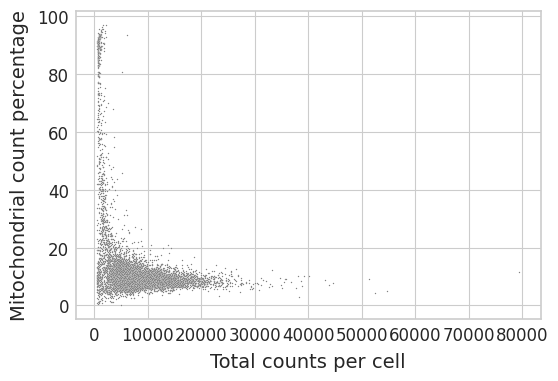

In [12]:
# Plot the number of transcripts present in each cell against the percentage of observed mitochondrial genes
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="pct_counts_mt", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Mitochondrial count percentage")

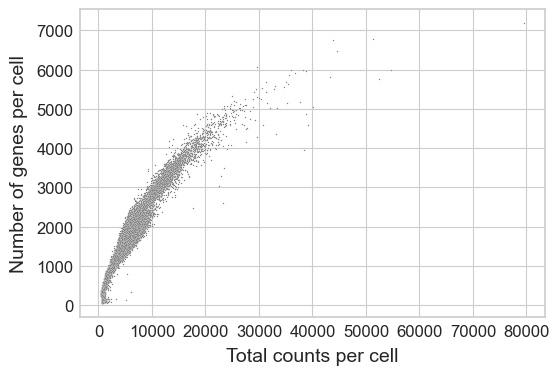

In [13]:
# Plot the number of transcripts present in each cell against the number of genes
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Number of genes per cell")
    plt.show()

In [14]:
# Remove likely dead/dying cells and data outliers
outlier_obs_mask = (adata.obs["total_counts"] > 30000).values | (adata.obs["pct_counts_mt"] > 45).values

adata = adata[~outlier_obs_mask, :].copy()
adata

AnnData object with n_obs × n_vars = 11373 × 17527
    obs: 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

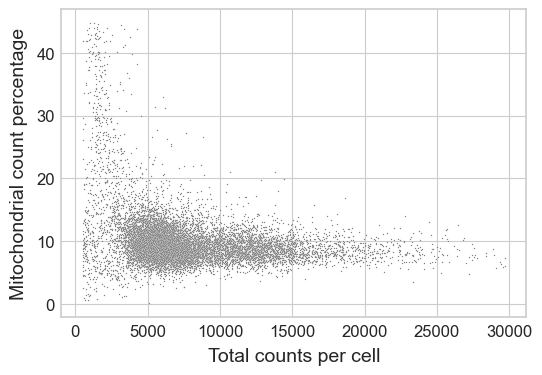

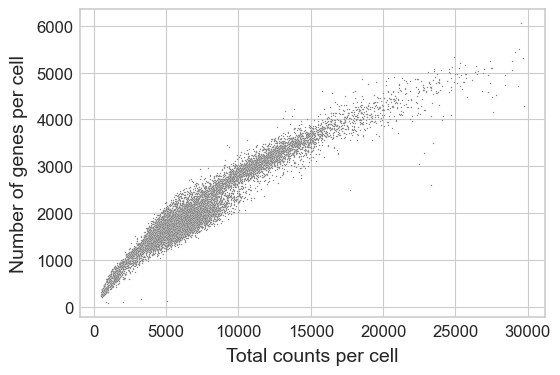

In [15]:
# Replot above's plots
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="pct_counts_mt", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Mitochondrial count percentage")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Number of genes per cell")
    plt.show()

## Data preprocessing

### Doublet detection

In [16]:
# Compute doublet statistics with scrublet
sc.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 4.8%
Estimated detectable doublet fraction = 59.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.1%
    Scrublet finished (0:00:35)


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


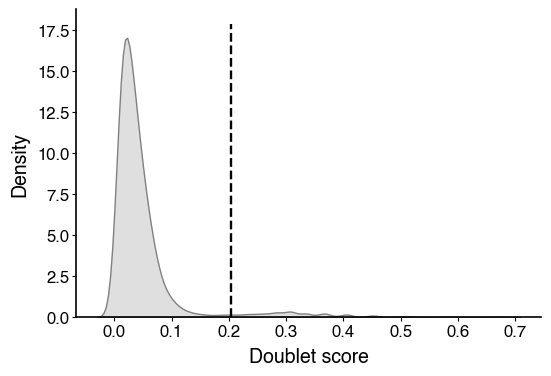

In [17]:
# Visualize the distribution of the doublet score
# Above which threshold is a cell considered a doublet?
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.kdeplot(data=adata.obs, x="doublet_score", color="gray", fill=True, ax=ax)
    ax.vlines(
        x=adata.obs.loc[adata.obs["predicted_doublet"], "doublet_score"].min(),
        ymin=0,
        ymax=ax.get_ylim()[1],
        colors="black",
        linestyles="--",
    )

    ax.set(xlabel="Doublet score")

    plt.show()

In [18]:
# How many cells does scrublet identify as putative doublets?
print(f"Number of cells identified as doublets: {adata.obs['predicted_doublet'].sum()}")
print(f"Percentage of cells identified as doublets: {adata.obs['predicted_doublet'].sum() / adata.n_obs * 100.:3}%")

Number of cells identified as doublets: 545
Percentage of cells identified as doublets: 4.792051349687857%


### Transformation and feature selection

In [19]:
# Normalize the cells to their median library size (total number of transcripts per cell)
sc.pp.normalize_total(adata)

normalizing counts per cell
    finished (0:00:00)


In [20]:
# Log1p transform the data
# Why do we use log1p transformation?
sc.pp.log1p(adata)

In [21]:
# Select the 4000 most highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=4000, subset=False)

extracting highly variable genes
    finished (0:00:00)


### Dimensionality reduction

In [22]:
# Compute the principal component embedding
sc.tl.pca(adata)

computing PCA
    with n_comps=50


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,


    finished (0:00:01)


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,


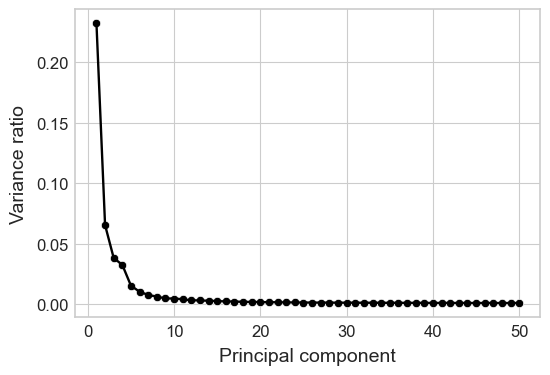

In [23]:
# What is a suitable number of principle components to use

n_pcs = len(adata.uns["pca"]["variance_ratio"])
with mplscience.style_context():
    sns.set_style("whitegrid")

    df = pd.DataFrame({"variance_ratio": adata.uns["pca"]["variance_ratio"], "pc": np.arange(start=1, stop=n_pcs + 1)})

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="pc", y="variance_ratio", color="black", ax=ax)
    sns.scatterplot(data=df, x="pc", y="variance_ratio", color="black", ax=ax)
    ax.set(xlabel="Principal component", ylabel="Variance ratio")

    plt.show()

In [24]:
# Compute a k-nearest neighbor graph with k=30
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)


computing UMAP
    finished (0:00:04)


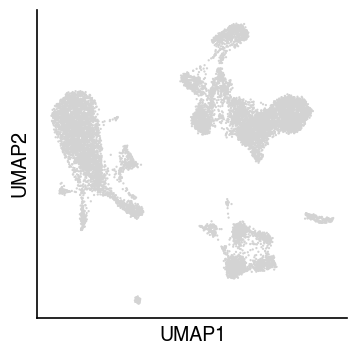

In [25]:
# Compute and plot the UMAP embedding of the data
sc.tl.umap(adata)

with mplscience.style_context():
    sc.pl.umap(adata)
    plt.show()

## Data clustering

In [26]:
# Compute a Leiden clustering of the data
sc.tl.leiden(adata)

running Leiden clustering


/var/folders/zn/c893vc250gzb72mhh01_t8lm0000gq/T/ipykernel_95208/2376076083.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished (0:00:03)


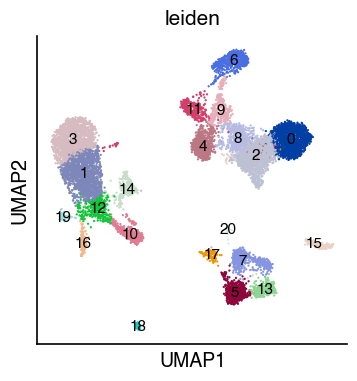

In [27]:
# Display the UMAP embedding, colored by leiden cluster
with mplscience.style_context():
    sc.pl.umap(adata, color="leiden", legend_loc="on data")
    plt.show()

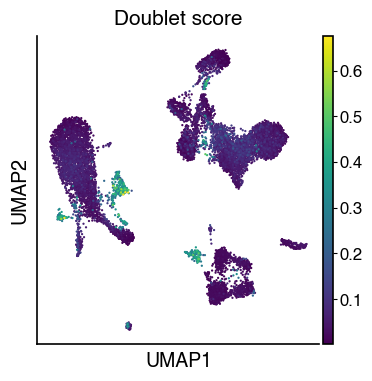

/var/folders/zn/c893vc250gzb72mhh01_t8lm0000gq/T/ipykernel_95208/1447972881.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


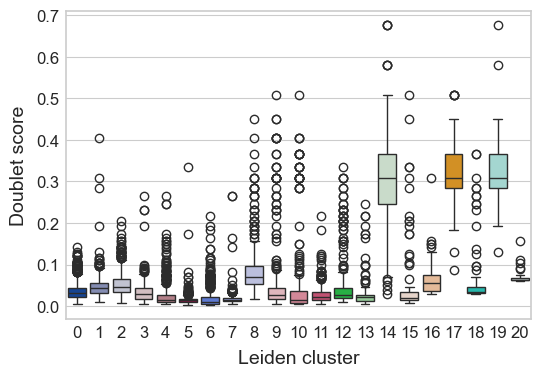

In [28]:
# Is there a cluster of cells likely comprised of doublets?
with mplscience.style_context():
    sc.pl.umap(adata, color="doublet_score", legend_loc="on data", title="Doublet score")
    plt.show()

with mplscience.style_context():
    sns.set_style("whitegrid")
    palette = dict(zip(adata.obs["leiden"].cat.categories, adata.uns["leiden_colors"]))
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=adata.obs, x="leiden", y="doublet_score", hue="leiden", palette=palette, ax=ax)
    ax.set(xlabel="Leiden cluster", ylabel="Doublet score")
    ax.legend().remove()
    plt.show()

## Cell typing

In [29]:
# Given the following cell type markers, assign cell types to clusters
# B cells: MS4A1, CD79A, IGHM
# T cells: CD4, CD8A, CD3D, CD3E, TRAC, LTB, IL7R, CCL4
# Natural killer cells: NKG7, KLRD1, PRF1, CD74, FCGR3A and low T cell marker expression
# Monocytes: CD14, CD163, TYROBP, LYZ, CSF1R, CD68

In [30]:
sc.tl.rank_genes_groups(adata=adata, groupby="leiden")

ranking genes
    finished (0:00:00)


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/scanpy/tools/_rank_gene

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: B, T, NK, etc.


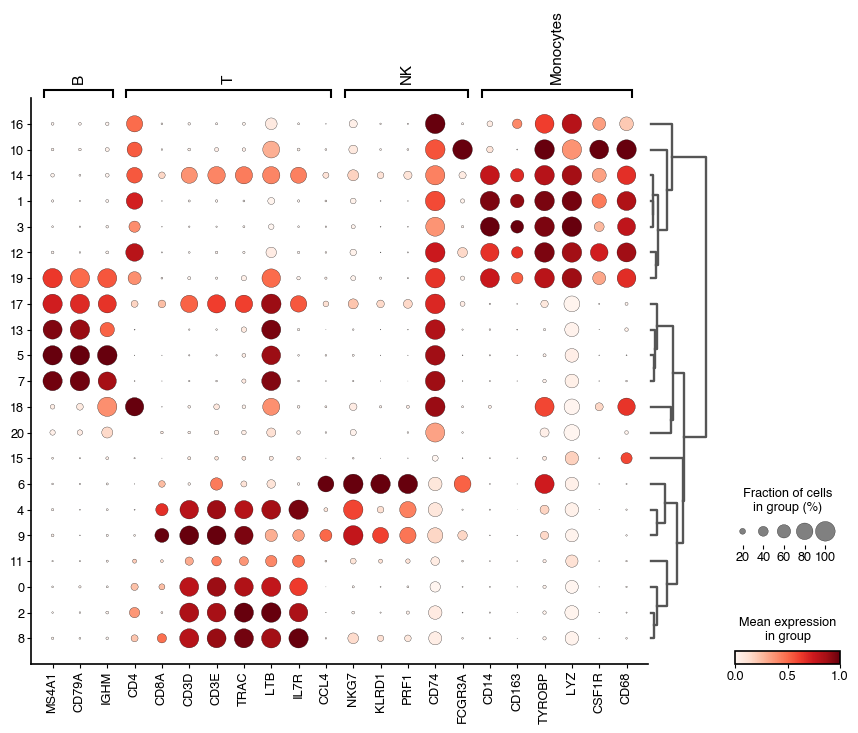

In [31]:
marker_dictionary = {
    "B": ["MS4A1", "CD79A", "IGHM"],
    "T": ["CD4", "CD8A", "CD3D", "CD3E", "TRAC", "LTB", "IL7R", "CCL4"],
    "NK": ["NKG7", "KLRD1", "PRF1", "CD74", "FCGR3A"],
    "Monocytes": ["CD14", "CD163", "TYROBP", "LYZ", "CSF1R", "CD68"],
}

with mplscience.style_context():
    sc.pl.rank_genes_groups_dotplot(
        adata,
        groupby="leiden",
        var_names=marker_dictionary,
        standard_scale="var",
    )